In [1]:
#Google Colab Mount
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('./gdrive/My Drive/Colab Notebooks/Projects/LinkedIn_FaceDetection/teeth_detection/')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

# CV
import cv2

# SK
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray

# Keras
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.models import Model, Sequential
from keras.applications.imagenet_utils import preprocess_input
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [3]:
files = glob.glob('./images_teeth/*.jpg')
image_array = []
image_label = []

for image in files:
  imagefile = cv2.imread(image)
  image_array.append(imagefile)
  image_label.append(1)

files = glob.glob('./images_no_teeth/*.jpg')
for image in files:
  imagefile = cv2.imread(image)
  image_array.append(imagefile)
  image_label.append(0)

image_npy = np.array(image_array)#, dtype = 'float32')
label_npy = np.array(image_label)#, dtype = 'float64')

image_npy.shape[0]

751

In [4]:
image_augment = []
label_augment = []

for i in range(len(image_npy)):
    flipped_image = cv2.flip(image_npy[i], 1)
    image_augment.append(flipped_image)
    label_augment.append(label_npy[i])

image_concat = np.concatenate((np.array(image_npy), np.array(image_augment)), axis=0)
label_concat = np.append(label_npy, np.array(label_augment))

print(len(image_concat))
print(len(image_npy))

1502
751


In [5]:
image_roi = []
def image_bounding_box(image):
  cascPath = "../haarcascade_frontalface_default.xml"
  faceCascade = cv2.CascadeClassifier(cascPath)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Detect faces in the image
  #faces = faceCascade.detectMultiScale(
  #    gray,
  #    scaleFactor=1.1,
  #    minNeighbors=5,
  #    minSize=(30, 30))

  # Draw a rectangle around the faces
  #if len(faces) != 1:
  #  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #  resize_roi = cv2.resize(image_gray, (48,48), interpolation = cv2.INTER_AREA)
  #  return resize_roi
  #else:
  #  for (x, y, w, h) in faces:
  #    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
  #    roi = image[y:y+h, x:x+w]
  #    #image_roi.append(roi)
  #    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
  #    resize_roi = cv2.resize(roi_gray, (48,48), interpolation = cv2.INTER_AREA)
  #    return resize_roi # gray image

  resize_roi = cv2.resize(gray, (48, 48), interpolation = cv2.INTER_AREA)
  return resize_roi

cnt = 0
for images in image_concat:
  image_roi.append(image_bounding_box(images))
  cnt = cnt + 1

In [6]:
print("Image Length: ", len(image_roi))
print("Label Length: ", len(label_concat))

Image Length:  1502
Label Length:  1502


In [71]:
gray = cv2.cvtColor(image_roi[0], cv2.COLOR_BGR2GRAY)
#plt.imshow(gray)

(48, 48, 3)


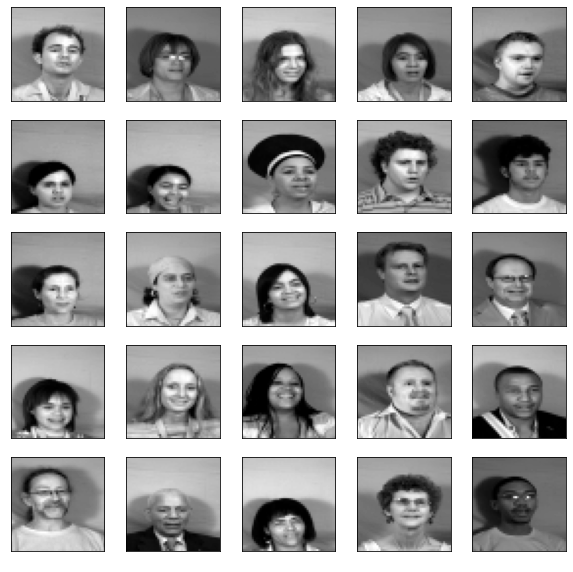

In [7]:
label = ['no teeth', 'teeth']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_roi[i], cmap = 'gray')
    plt.xlabel(label[label_concat[i]], color='white')
plt.show()

In [8]:
image_df = pd.DataFrame([[image] for image in image_roi], columns = ['image'])
image_df['labels'] = label_concat

X = list(image_df['image'].values)
y = list(image_df['labels'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=24)

In [9]:
image_train = np.array(X_train)
image_valid = np.array(X_valid)

# Convert labels to one-hot vectors       
label_train = keras.utils.to_categorical(y_train, num_classes=2)
label_valid = keras.utils.to_categorical(y_valid, num_classes=2)
print("image_train", image_train.shape)
print("image_valid", image_valid.shape)
print("label_train", label_train.shape)
print("label_valid", label_valid.shape)

image_train (1201, 48, 48)
image_valid (301, 48, 48)
label_train (1201, 2)
label_valid (301, 2)


In [11]:
image_size = 48
cnn_model = Sequential()

# Reshape Layer
cnn_model.add(keras.layers.Reshape((image_size, image_size, 1), input_shape=(image_size, image_size)))
#cnn_model.add(keras.layers.Re)
# Add Augmentation Layers
cnn_model.add(RandomFlip('horizontal'))
cnn_model.add(RandomRotation(0.2))

# Convolution Layer 1
cnn_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())

# Convolution Layer 2
cnn_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.2))

# Convolution Layer 3
cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())

# Convolution Layer 4
cnn_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.3))

# Convolution Layer 5
cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())

# Convolution Layer 6
cnn_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.4))

# Fully connected Dense Layers with dropout
cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(2, activation='softmax'))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 48, 48, 1)         0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 48, 48, 1)         0         
_________________________________________________________________
random_rotation (RandomRotat (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)       

In [12]:
cnn_model.compile(loss='categorical_crossentropy',
               optimizer='adam',
              metrics=['accuracy'])

In [13]:
history = cnn_model.fit(image_train, label_train, batch_size=256, epochs=500, validation_data=(image_valid, label_valid))

Epoch 1/500
5/5 [==============================] - 24s 4s/step - loss: 1.2999 - accuracy: 0.5177 - val_loss: 6.2678 - val_accuracy: 0.4983
Epoch 2/500
5/5 [==============================] - 25s 4s/step - loss: 1.2455 - accuracy: 0.5054 - val_loss: 14.4859 - val_accuracy: 0.4983
Epoch 3/500
5/5 [==============================] - 22s 4s/step - loss: 1.1329 - accuracy: 0.5265 - val_loss: 13.7970 - val_accuracy: 0.4983
Epoch 4/500
5/5 [==============================] - 22s 4s/step - loss: 0.9932 - accuracy: 0.5257 - val_loss: 3.8328 - val_accuracy: 0.4718
Epoch 5/500
5/5 [==============================] - 22s 4s/step - loss: 0.9790 - accuracy: 0.5130 - val_loss: 3.3621 - val_accuracy: 0.4651
Epoch 6/500
5/5 [==============================] - 23s 4s/step - loss: 0.9396 - accuracy: 0.5306 - val_loss: 5.1924 - val_accuracy: 0.4983
Epoch 7/500
5/5 [==============================] - 22s 4s/step - loss: 0.9611 - accuracy: 0.5167 - val_loss: 5.1703 - val_accuracy: 0.4983
Epoch 8/500
5/5 [========

In [14]:
cnn_model.save('model_teeth_nobound.h5')

cnn_model.evaluate(image_valid, label_valid)

10/10 [==============================] - 1s 134ms/step - loss: 0.4911 - accuracy: 0.8638


[0.49114471673965454, 0.8637873530387878]